In [1]:
%cd ~/critic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import torch

is_dark = False
theme, cs = rp.mpl_setup(is_dark)

/home/nmiklaucic/critic


In [2]:
df = pd.read_feather('precomputed/all_typos.feather')
df

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i
1,substitute,True,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,20,19.0,Can you help get this c,␣,s
2,omission,False,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,t,
3,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,25,NaN,Doctors gave him 10 years to,␣,t
4,insertion,True,469,1.0,Doctors gave him 10 years ␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years¬␣␣␣␣␣␣␣␣␣␣␣␣to live ...,Doctors gave him 10 years␣ t liv␈␈␈␈␈␈to live ...,26,NaN,Doctors gave him 10 years to,,t
...,...,...,...,...,...,...,...,...,...,...,...,...
35626,omission,True,517599,1.0,"Currently, we are focusing our ␣␣resources on ...","currently, we are focusing our ␣␣resources on ...","currently, we are focusing our e␈resources on ...",33,NaN,"Currently, we are focusing our res",e,r
35627,substitute,False,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,0,0.0,The,t,T
35628,substitute,True,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,6,4.0,The res,d,r
35629,substitute,True,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,13,11.0,The reserve,c,v


In [3]:
metadata = pd.read_csv('data/keystrokes/metadata_participants.txt', sep='\t').set_index('PARTICIPANT_ID')
metadata

,AGE,GENDER,HAS_TAKEN_TYPING_COURSE,COUNTRY,LAYOUT,NATIVE_LANGUAGE,FINGERS,TIME_SPENT_TYPING,KEYBOARD_TYPE,ERROR_RATE,AVG_WPM_15,AVG_IKI,ECPC,KSPC,ROR
PARTICIPANT_ID,,,,,,,,,,,,,,,
3,30,none,0,US,qwerty,en,1-2,8,full,0.511945,61.9483,169.224722,0.052901,1.151877,0.2288
5,27,female,0,MY,qwerty,en,7-8,6,laptop,0.871080,72.8871,150.457375,0.031469,1.101399,0.3675
7,13,female,0,AU,qwerty,en,7-8,0,laptop,6.685633,24.1809,386.575303,0.092105,1.292398,0.0667
23,21,female,0,IN,qwerty,en,3-4,0,full,2.130493,24.7112,457.947902,0.016624,1.072890,0.0413
24,21,female,0,PH,qwerty,tl,7-8,1,laptop,1.893287,45.3364,223.913395,0.045296,1.177700,0.2678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517932,20,male,0,US,qwerty,en,9-10,2,laptop,8.731466,24.9125,392.646012,0.116638,1.245283,0.1842
517936,25,male,0,PL,qwerty,pl,9-10,1,laptop,0.000000,66.2946,166.587565,0.023932,1.095726,0.0639
517943,38,female,1,US,qwerty,en,9-10,3,laptop,0.147929,75.6713,138.880622,0.057607,1.140325,0.2021


In [4]:
from logging import warning


QWERTY = """
qwertyuiop
asdfghjkl;
zxcvbnm,./
""".strip()

WIDTH = len(QWERTY.split('\n')[0])
HEIGHT = len(QWERTY.split('\n'))

LETTERS = QWERTY.replace('\n', '')

def get_xy(char):
    if char.lower() not in LETTERS:
        warning(f'{char.lower()} not found, using (0, 0)')
        return (0, 0)
    else:
        i = LETTERS.index(char.lower())
        return (i % WIDTH, HEIGHT - (i // WIDTH) - 1)

df = df[df['wrong_char'].str.lower().isin(set(QWERTY)) & df['right_char'].str.lower().isin(set(QWERTY))]
df = df.reset_index(drop=True)
df['wrong_xy'] = df['wrong_char'].apply(get_xy)
df['right_xy'] = df['right_char'].apply(get_xy)
df[['wrong_x', 'wrong_y']] = pd.DataFrame(df['wrong_xy'].tolist())
df[['right_x', 'right_y']] = pd.DataFrame(df['right_xy'].tolist())
df

,kind,corrected,participant,weight,p,t,ist,i,j,context,wrong_char,right_char,wrong_xy,right_xy,wrong_x,wrong_y,right_x,right_y
0,omission,False,469,1.0,Can you help get this cleared up?,Can you help get th¬s cleared up?,Can you help get th␣s cleared up?,19,NaN,Can you help get this,s,i,"(1, 1)","(7, 2)",1,1,7,2
1,substitute,True,469,1.0,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,he has ␈␈␈␈␈␈␈␈He has developed a good on-file...,15,0.0,He,h,H,"(5, 1)","(5, 1)",5,1,5,1
2,insertion,True,469,1.0,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,he has ␈␈␈␈␈␈␈␈He has developed a good on-file...,44,NaN,He has developed a good on-fie,l,i,"(8, 1)","(7, 2)",8,1,7,2
3,omission,True,469,1.0,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,he has ␈␈␈␈␈␈␈␈He has developed a good on-file...,61,NaN,He has developed a good on-field,d,l,"(2, 1)","(8, 1)",2,1,8,1
4,omission,True,469,1.0,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣He has developed a good on-f␣␣␣...,he has ␈␈␈␈␈␈␈␈He has developed a good on-file...,59,NaN,He has developed a good on-fiel,e,i,"(2, 2)","(7, 2)",2,2,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22824,omission,True,517599,1.0,"Currently, we are focusing our ␣␣resources on ...","currently, we are focusing our ␣␣resources on ...","currently, we are focusing our e␈resources on ...",33,NaN,"Currently, we are focusing our res",e,r,"(2, 2)","(3, 2)",2,2,3,2
22825,substitute,False,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,0,0.0,The,t,T,"(4, 2)","(4, 2)",4,2,4,2
22826,substitute,True,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,6,4.0,The res,d,r,"(2, 1)","(3, 2)",2,1,3,2
22827,substitute,True,517599,1.0,The ␣␣reser␣␣ve wi␣␣deout is day-to-day.,the ␣␣reser␣␣ve wi␣␣dwout is day-to-day.,the d␈reserc␈ve wid␈dwout is day-to-day.,13,11.0,The reserve,c,v,"(2, 0)","(3, 0)",2,0,3,0


In [5]:
df['kind_code'] = pd.Categorical(df['kind'], categories=('omission', 'insertion', 'substitute', 'transpose')).codes
counts = pd.value_counts(df['right_char'].str.lower())
df['freq'] = (sum(counts) / counts[df['right_char'].str.lower()]).values
df['freq']

/tmp/ipykernel_1432306/222145314.py:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(df['right_char'].str.lower())


0        11.301485
1        20.474439
2        11.301485
3        28.218789
4        11.301485
           ...    
22824    20.566667
22825    12.293484
22826    20.566667
22827    50.173626
22828    11.816253
Name: freq, Length: 22829, dtype: float64

In [6]:
import os

# This guide can only be run with the JAX backend.
os.environ["KERAS_BACKEND"] = "torch"

import keras
from keras import layers as nn
from keras import ops

VOWELS = ops.array([list(get_xy(c)) for c in 'aeiou'])


class KbdModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.tilt = self.add_weight((), initializer='zeros')
        self.aspect_ratio = self.add_weight((), initializer='zeros')
        # omission, insertion, substitute, transpose
        self.category_logits = self.add_weight((4,), initializer='normal')
        self.two_hand_logit = self.add_weight((), initializer='zeros')
        self.vowel_logit = self.add_weight((), initializer='zeros')
        self.scale = self.add_weight((), initializer='zeros')
        self.power = self.add_weight((), initializer=lambda shape, dtype: 2 * keras.initializers.Ones()(shape, dtype))

    def kbd_layout_dist(self, delta):
        x = ops.sigmoid(self.aspect_ratio)
        y = 1 - x

        cov = ops.diag([x, y]) * ops.exp(self.scale)

        cost = ops.cos(self.tilt)
        sint = ops.sin(self.tilt)

        # R = ops.convert_to_tensor([[cost, -sint], [sint, cost]])
        R = torch.stack([cost, -sint, sint, cost]).reshape(2, 2)

        dist = torch.distributions.MultivariateNormal(ops.zeros(2, dtype=torch.float32), ops.matmul(ops.matmul(R, cov), R.T))
        return dist.log_prob(ops.sqrt(ops.abs(delta) + 1e-6) ** (self.power))
    
    def category_probs(self):
        return ops.log_softmax(self.category_logits)

    def insertion_log_prob(self, wrong_xy, right_xy):
        delta = right_xy - wrong_xy
        return self.kbd_layout_dist(delta)
    
    def omission_log_prob(self, wrong_xy, right_xy):
        return self.kbd_layout_dist(wrong_xy * 0)
    
    def substitute_log_prob(self, wrong_xy, right_xy):
        delta = right_xy - wrong_xy
        wrong_vowel = (wrong_xy[..., None, :] == VOWELS[None, ...]).all(axis=-1).any(axis=-1)
        right_vowel = (wrong_xy[..., None, :] == VOWELS[None, ...]).all(axis=-1).any(axis=-1)
        vowel_prob = (wrong_vowel & right_vowel).to(torch.float32)

        a, b = ops.log_sigmoid(self.vowel_logit), ops.log_sigmoid(-self.vowel_logit)
        vowel_prob = ops.where(vowel_prob, a, b)

        return vowel_prob + self.kbd_layout_dist(delta)
    
    def transpose_log_prob(self, wrong_xy, right_xy):
        delta = right_xy - wrong_xy
        wrong_lh = wrong_xy[..., 0] <= 4
        right_lh = right_xy[..., 0] <= 4
        two_hand_prob = (wrong_lh != right_lh).to(torch.float32)

        a, b = ops.log_sigmoid(self.two_hand_logit), ops.log_sigmoid(-self.two_hand_logit)
        two_hand_prob = ops.where(two_hand_prob, a, b)

        return two_hand_prob + self.kbd_layout_dist(delta * 0) # self.gaussian().log_prob(delta)
    
    def log_prob(self, kind, wrong_xy, right_xy):
        cond_probs = []
        for meth in (self.omission_log_prob, self.insertion_log_prob, self.substitute_log_prob, self.transpose_log_prob):
            cond_probs.append(meth(wrong_xy, right_xy))
            # print(cond_probs[-1].shape)

        probs = ops.array(cond_probs) + self.category_probs()[..., None]
        # print(cond_probs.shape)
            
        probs = probs * (ops.arange(4)[..., None] == kind[None, ...])
        probs = probs.sum(axis=0)

        return probs
    
    def call(self, inputs):
        kind, wrong_xy, right_xy = inputs
        return -self.log_prob(kind, wrong_xy, right_xy)
    

mod = KbdModel()

def process_inputs(subs):
    kind = ops.array(subs['kind_code'])
    wrong_xy = ops.array(list(map(list, subs['wrong_xy']))).to(torch.float32)
    right_xy = ops.array(list(map(list, subs['right_xy']))).to(torch.float32)
    return kind, wrong_xy, right_xy

# mod.insertion_log_prob(*process_inputs(df.iloc[:64])[1:])
mod.log_prob(*process_inputs(df.iloc[:64]))

tensor([ -2.5190,  -3.2315,  -4.6422,  -2.5190,  -2.5190,  -4.2315,  -3.2315,
        -52.2315,  -3.6422,  -3.6422,  -3.2315,  -3.2315,  -2.5190,  -2.5190,
         -8.2315,  -2.5190,  -2.5190,  -2.5190,  -4.2315,  -2.5190,  -2.5190,
         -4.2315, -12.6422,  -3.2315,  -8.2315,  -2.5190,  -3.6422,  -2.5190,
         -3.2315,  -2.5190, -20.2315,  -4.2315,  -4.2315,  -5.2315,  -2.5190,
         -2.5190, -27.6423,  -4.2315,  -3.2315,  -3.2315,  -3.2315,  -3.2315,
         -4.2315,  -2.5190, -11.6422,  -3.2315,  -2.5190, -52.6423,  -4.2315,
        -12.2315, -12.2315,  -8.2315, -12.6422,  -2.5190, -15.6423,  -4.2315,
        -12.2315,  -3.1285,  -3.6422,  -2.5190,  -3.6422,  -2.5190,  -3.2315,
         -2.5190], device='cuda:0', grad_fn=<SumBackward1>)

Epoch 1/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.9843 - val_loss: 4.5675
Epoch 2/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7087 - val_loss: 3.8982
Epoch 3/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.1496 - val_loss: 3.6366
Epoch 4/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.9184 - val_loss: 3.4714
Epoch 5/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7503 - val_loss: 3.3393
Epoch 6/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5902 - val_loss: 3.2293
Epoch 7/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.4370 - val_loss: 3.1385
Epoch 8/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.3553 - val_loss: 3.0623
Epoch 9/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.2608 - val_loss: 2.9969
Epoch 10/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.1865 - val_loss: 2.9318
Epoch 11/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.1415 - val_loss: 2.8500
Epoch 12/25
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9

[array(0.71437603, dtype=float32),
 array(2.881664, dtype=float32),
 array([ 0.06552168, -0.6870128 ,  1.1382339 , -1.6038157 ], dtype=float32),
 array(0.41813257, dtype=float32),
 array(-1.3871826, dtype=float32),
 array(-0.16270475, dtype=float32),
 array(0.05357886, dtype=float32)]

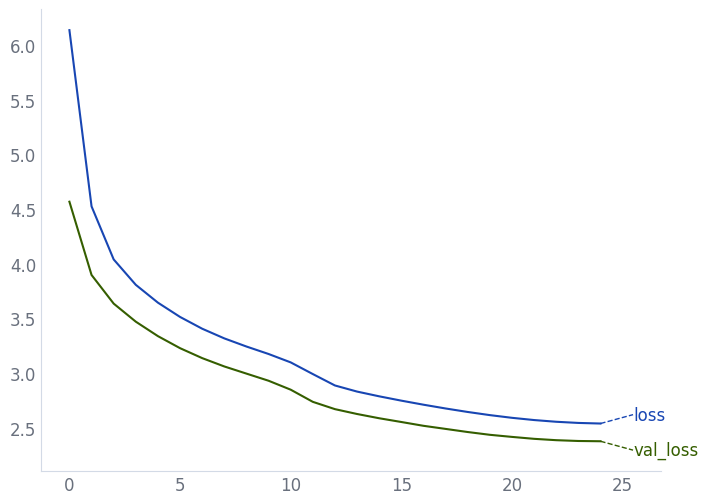

In [7]:
from keras.optimizers.schedules import PolynomialDecay

subs =  df.iloc[::]
inputs = process_inputs(subs)
weights = ops.array(subs['weight']) * ops.array(subs['freq'])

weights = weights / torch.mean(weights)

def fit(epochs=25, valid_split=0.05, batch_size=256):
    mod = KbdModel()
    mod([k[:batch_size] for k in inputs])

    steps_in_epoch = round((inputs[0].shape[0] * (1 - valid_split)) / (batch_size) + 0.5)

    decay_steps = steps_in_epoch * epochs

    def log_prob_loss(y_true, y_pred):
        return y_pred

    mod.compile(optimizer=keras.optimizers.Adam(
        learning_rate=PolynomialDecay(4e-3, decay_steps, end_learning_rate=1e-6), 
        global_clipnorm=3.0), loss=log_prob_loss)

    history = mod.fit(inputs, inputs[0].to(torch.float32) * 0, batch_size=batch_size, epochs=epochs, validation_split=valid_split, sample_weight=weights)

    pd.DataFrame(history.history).plot()
    rp.line_labels()
    
    return mod, history

mod, history = fit()
mod.get_weights()

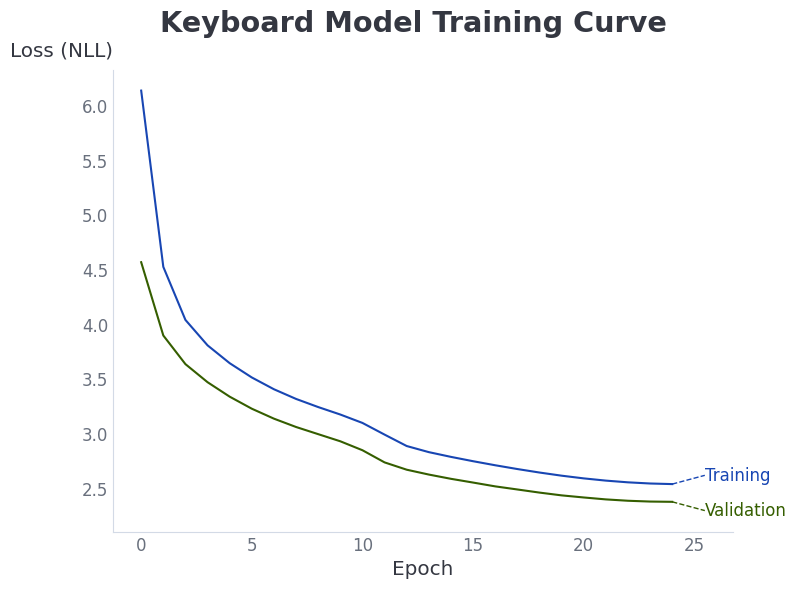

In [8]:
plot_df = pd.DataFrame(history.history)
plot_df.columns = ['Training', 'Validation']
plot_df.plot()
rp.line_labels()
plt.suptitle('Keyboard Model Training Curve')
plt.ylabel('Loss (NLL)')
plt.xlabel('Epoch')
rp.ylabel_top()

In [12]:
from scipy.special import softmax
c = df['kind_code'].value_counts().sort_index().values
c = c / np.sum(c)
print(c.round(2))
print(softmax(mod.get_weights()[2]).round(2))

[0.26 0.12 0.57 0.05]
[0.22 0.1  0.64 0.04]


In [9]:
subs = df.iloc[:2048]
subs['nll'] = mod(process_inputs(subs))

display(subs.sort_values('nll', ascending=False).head(20).drop(columns=['t', 'wrong_xy', 'right_xy', 'kind_code']))

/tmp/ipykernel_3278980/2307156966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['nll'] = mod(process_inputs(subs))


,kind,corrected,participant,weight,p,ist,i,j,context,wrong_char,right_char,wrong_x,wrong_y,right_x,right_y,freq,nll
1745,insertion,True,40685,1.0,I would like ␣␣␣␣it paid ␣␣␣␣through I ␣␣Buy It.,I would like ti␈␈it paid bt␈␈through I b␈Buy It.,25,NaN,I would like it paid th,b,t,4,0,4,2,12.293484,6.931558
886,insertion,True,22599,1.0,Don't expect Sanders to play an␣␣␣␣ytime soon.,Don't expect Sanders to play a␣ny␈␈ytime soon.,31,NaN,Don't expect Sanders to play anyt,n,y,5,0,5,2,34.432881,6.931558
743,insertion,True,20379,1.0,More than million landmines lie un␣␣␣␣expl␣␣od...,More than million landmines lie unce␈␈expla␈od...,34,NaN,More than million landmines lie unex,c,e,2,0,2,2,11.816253,6.931558
180,substitute,False,5291,1.0,Drop him ␣␣if he was on your Fantasy roster.¬¬,Drop him o␈if he was ␣␣␣your Fantasy rosteron,43,43.0,Drop him if he was on your Fantasy roster.¬¬,o,.,8,2,8,0,32.847482,6.738018
1160,substitute,False,29372,1.0,␣␣There␣␣ was no such accord.,h␈Therew␈ was no such record.,23,23.0,There was no such acco,e,c,2,2,2,0,29.118622,6.738018
799,substitute,True,21089,1.0,What nu␣␣mber sho␣␣␣␣␣␣␣␣uld he call yo␣␣u on␣...,what nuu␈mber shoyld ␈␈␈␈uld he call yoy␈u on/...,9,7.0,What numbe,u,m,6,2,6,0,33.770710,6.738018
60,insertion,True,3374,1.0,I'm tak␣␣␣␣ing Wednesday off.¬,I'm ta␣ki␈␈ing Wednesday off.,7,NaN,I'm takin,k,i,7,1,7,2,11.301485,6.601104
1605,insertion,True,35580,1.0,Tr␣␣␣␣␣␣␣␣y and re␣␣-draft and let me ␣␣know.,Tryh ␈␈␈ ␈y a␣d red␈-draft and let me n␈know.,3,NaN,Try,h,y,5,1,5,2,34.432881,6.601104
557,insertion,True,13753,1.0,They laun␣␣ched a counter attack¬¬ and retook ...,They launc␈ched a ␣ounter attacked and retook ...,65,NaN,They launched a counter attack¬¬ and retook po...,e,d,2,2,2,1,26.060502,6.601104
484,insertion,True,12036,1.0,He refused to ␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣␣elaborate on...,he refused to delay to e␈␈␈␈␈␈␈␈␈␈elaborate on...,14,NaN,He refused to el,d,e,2,1,2,2,11.816253,6.601104


<Axes: xlabel='kind', ylabel='count'>

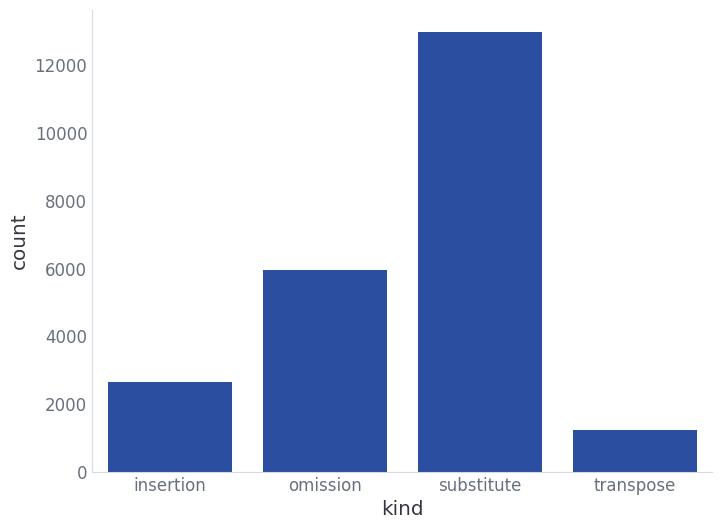

In [10]:
sns.countplot(df, x='kind')

<Axes: xlabel='right_char', ylabel='count'>

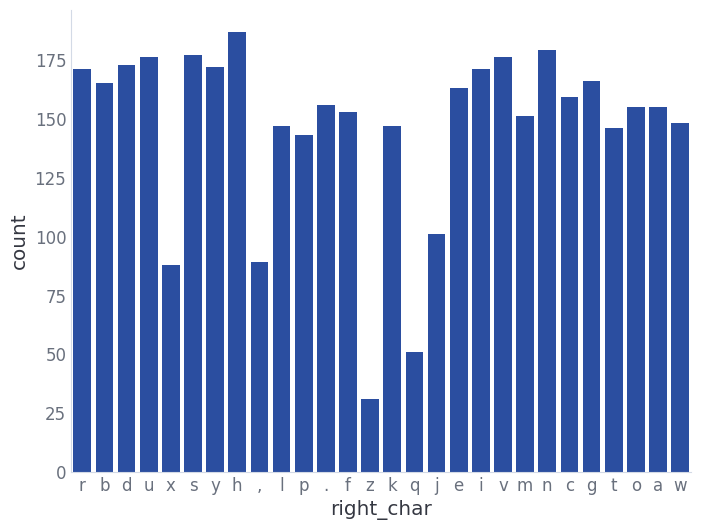

In [11]:
sample = df.sample(4096, weights=df['freq'])
sns.countplot(sample, x=sample['right_char'].str.lower())

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

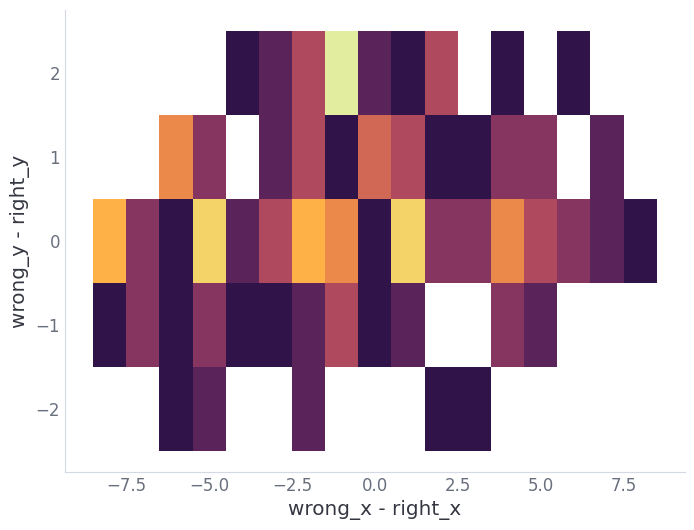

In [12]:
sns.histplot(sample.query('kind == "transpose"'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap)

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

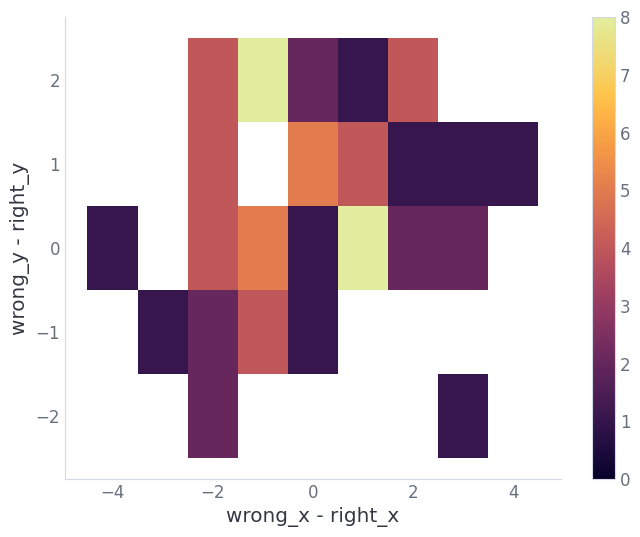

In [13]:
sns.histplot(sample.query('kind == "transpose" and (wrong_x <= 4) == (right_x <= 4)'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap, cbar=True)

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

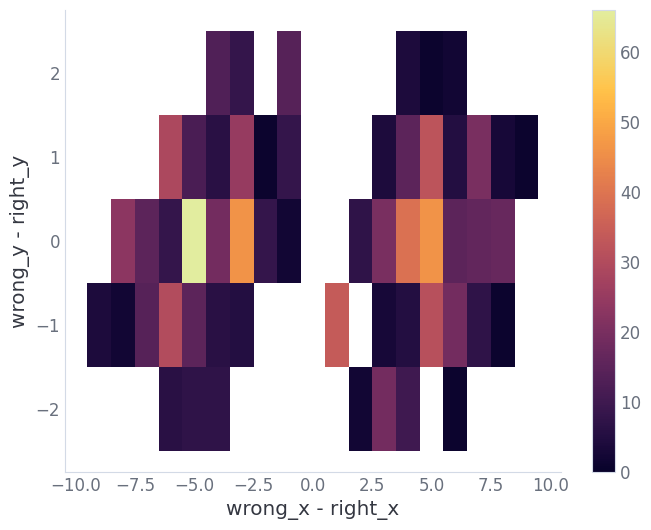

In [14]:
sns.histplot(df.query('kind == "transpose" and (wrong_x <= 4) != (right_x <= 4)'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap, cbar=True)

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

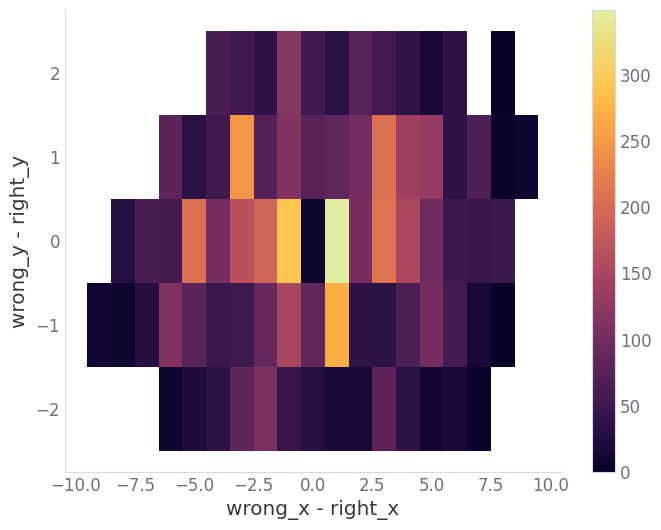

In [15]:
sns.histplot(df.query('kind == "omission"'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap, cbar=True)

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

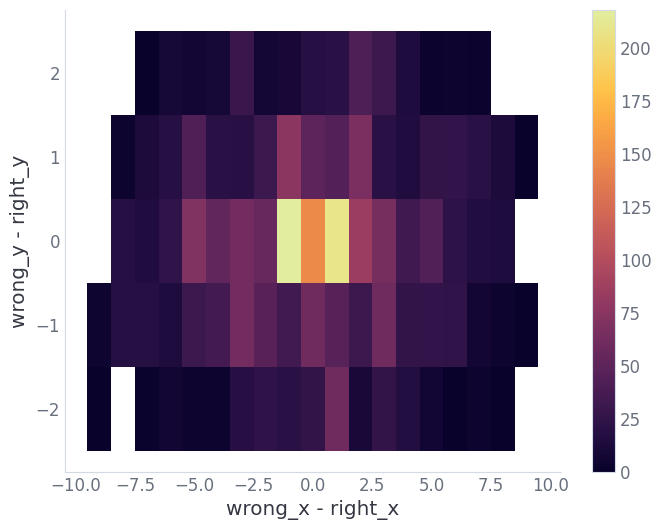

In [16]:
sns.histplot(df.query('kind == "insertion"'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap, cbar=True)

<Axes: xlabel='wrong_x - right_x', ylabel='wrong_y - right_y'>

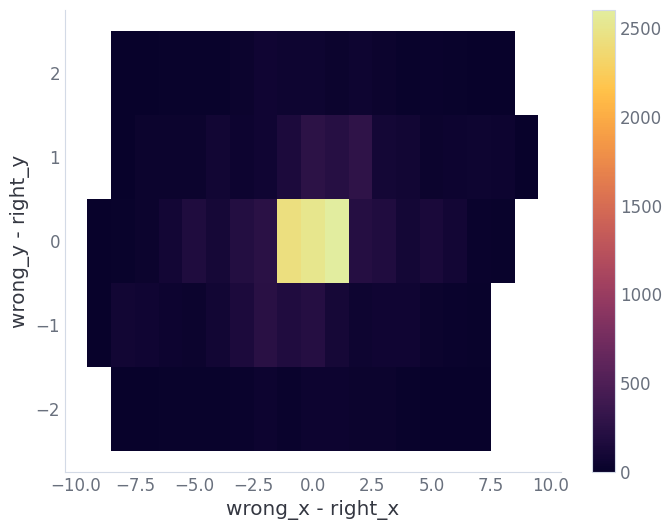

In [17]:
sns.histplot(df.query('kind == "substitute"'), x='wrong_x - right_x', y='wrong_y - right_y', discrete=True, cmap=rp.mpl_heatmap, cbar=True)

In [18]:
# df.to_csv('precomputed/all_typos.csv')

In [19]:
from collections import defaultdict
from dataclasses import dataclass
from typing import Literal

type EditKind = Literal['omit', 'insert', 'sub', 'transpose']

EOS = '_'

EDIT_KINDS = ['omit', 'insert', 'sub', 'transpose']

def prev_index(kind: EditKind | None, i, j):
    if kind == 'omit':
        return i, j - 1
    elif kind == 'insert':
        return i - 1, j
    elif kind == 'sub':
        return i - 1, j - 1
    elif kind == 'transpose':
        return i - 2, j - 2
    elif kind is None:
        return i - 1, j - 1

@dataclass
class Edit:
    kind: EditKind
    wrong_char: str
    right_char: str    

    def as_numerical(self):
        return EDIT_KINDS.index(self.kind), get_xy(self.wrong_char), get_xy(self.right_char)

str1 = 'tere'
str2 = 'atre'


def align(str1, str2):
    m, n = (len(str1) + 1, len(str2) + 1)

    str1 += EOS
    str2 += EOS

    d = np.zeros((m, n))

    d[:, 0] = np.arange(m)
    d[0, :] = np.arange(n)

    edit_paths = defaultdict(list)

    for i in range(1, m):
        d[i, 0] = i
        edit_paths[(i, 0)].append(Edit('insert', str1[i - 1], EOS))

    for j in range(1, n):
        d[0, j] = j
        edit_paths[(0, j)].append(Edit('omit', EOS, str2[j - 1]))

    for i in range(1, m):
        for j in range(1, n):
            if str1[i - 1] == str2[j - 1]:
                cost = 0
                sub = None
            else:
                cost = 1
                sub = Edit('sub', str1[i - 1], str2[j - 1])
            edits = [
                Edit('insert', str1[i - 1], str2[j]),
                Edit('omit', str1[i], str2[j - 1]),
                sub,
            ]
            costs = [
                d[i - 1, j] + 1,  # omit
                d[i, j - 1] + 1,  # insert
                d[i - 1, j - 1] + cost,   # substitute
            ]

            if i > 1 and j > 1 and str1[i-2:i][::-1] == str2[j-2:j] and str1[i-2] != str1[i-1]:
                # transposition possible
                costs.append(d[i - 2, j - 2] + 1)
                edits.append(Edit('transpose', str1[i - 2], str1[i - 1]))

            min_cost = min(costs)
            d[i, j] = min_cost

            for edit, cost in zip(edits, costs):
                if cost == min_cost:
                    edit_paths[(i, j)].append(edit)

    # pd.DataFrame(d.astype(int), index=[str1[:i] for i in range(m)], columns=[str2[:i] for i in range(n)])
    return edit_paths
                

def all_paths(ij, edit_paths):
    if ij == (0, 0):
        return [[]]
    
    paths = []
    for edit in edit_paths[ij]:
        edit_kind = None if edit is None else edit.kind
        new_ij = prev_index(edit_kind, *ij)
        paths.extend([path + [edit] for path in all_paths(new_ij, edit_paths)])
    
    return paths
            
    
edit_paths = align('teretesting', 'treeetesting')

paths = all_paths(max(edit_paths.keys()), edit_paths)
paths

# {
#     (str1[:i], str2[:j]): v for (i, j), v in edit_paths.items()
# }

[[None,
  Edit(kind='transpose', wrong_char='e', right_char='r'),
  None,
  Edit(kind='omit', wrong_char='t', right_char='e'),
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  Edit(kind='transpose', wrong_char='e', right_char='r'),
  Edit(kind='omit', wrong_char='e', right_char='e'),
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 [None,
  Edit(kind='omit', wrong_char='e', right_char='r'),
  None,
  Edit(kind='sub', wrong_char='r', right_char='e'),
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

In [20]:

def total_log_prob(paths):
    probs = []
    for path in paths:
        x0 = []
        x1 = []
        x2 = []
        for edit in path:
            if edit is not None:
                kind, wrong, right = edit.as_numerical()
                x0.append(kind)
                x1.append(list(wrong))
                x2.append(list(right))

        x0 = np.array(x0)
        x1 = np.array(x1)
        x2 = np.array(x2)        
        if x0.size:
            path_probs = mod.log_prob(x0, x1, x2)
            probs.append(np.sum(path_probs))
        else:
            probs.append(0)

    return jax.nn.logsumexp(np.array(probs)).item()

total_log_prob(paths)

-3.6812679767608643

In [21]:
from scipy.special import softmax
def kbd_log_prob(str1, str2):
    edit_paths = align(str1, str2)

    paths = all_paths(max(edit_paths.keys()), edit_paths)

    return total_log_prob(paths)

options = ['tere', 'tear', 'tree', 'terr', 'ere', 'tee', 'terse', 'there', 'sere', 'tire', 'tare', 'tern', 'tore', 'term', 'mere', 'here', 'were']

probs = pd.Series([kbd_log_prob(option, 'tere') for option in options], options)

probs.loc[:] = softmax(probs)
probs.sort_values(ascending=False)

tere     0.457901
terr     0.107557
were     0.097151
tee      0.046158
ere      0.046158
sere     0.038628
term     0.033888
here     0.033768
tern     0.032665
mere     0.030965
tire     0.022682
tore     0.022214
tare     0.009082
there    0.007852
terse    0.006864
tree     0.003436
tear     0.003030
dtype: float64

In [22]:
from dataclasses import dataclass
from typing import Sequence

@dataclass
class Corrections:
    """Possible corrections for a single word."""
    # Words to correct to.
    words: Sequence[str]

    # Probabilities for each word.
    probs: Sequence[float]

    def as_series(self) -> pd.Series:
        """Returns a sorted pd.Series."""
        return pd.Series(self.probs, self.words).sort_values(ascending=False)

class Corrector:
    """A model for correcting words in context."""

    def push_word(self, word: str):
        """Adds the (correct) word to the existing context."""
        raise NotImplementedError()

    def clear_context(self):
        """Resets context."""
        raise NotImplementedError()

    def correct(self, word: str) -> Corrections:
        """Computes potential corrections for a word, given previous context."""
        raise NotImplementedError()

In [23]:
from transformers import AutoConfig, FlaxAutoModelForCausalLM, AutoTokenizer

model_name = 'distilbert/distilgpt2'
model = FlaxAutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

ModuleNotFoundError: No module named 'transformers'